In [1]:
# CARGAR LIBRERIAS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# CARGAR BASES DE DATOS

df = pd.read_csv('../BBDD/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# SUSTITUIR EN COLUMNA 'EVER_MARRIED' NO POR 0 Y YES POR 1

df.loc[df['ever_married'] == 'No', 'ever_married'] = 0
df.loc[df['ever_married'] == 'Yes', 'ever_married'] = 1

In [6]:
# SUSTITUIR EN COLUMNA 'GENDER' FEMALE POR 0 Y MALE POR 1
df.loc[df['gender'] == 'Female', 'gender'] = 0
df.loc[df['gender'] == 'Male', 'gender'] = 1

In [7]:
# SUSTITUIR EN COLUMNA 'RESIDENCE TYPE' RURAL POR 0 Y URBAN POR 1
df.loc[df['Residence_type'] == 'Rural', 'Residence_type'] = 0
df.loc[df['Residence_type'] == 'Urban', 'Residence_type'] = 1

In [8]:
# BORRAR NANS
# HACER KNN IMPUTER EN BMI

df.dropna(inplace=True)

In [11]:
# COMPROBAR CON UNA MASCARA SI HAY ALGUNA FILA CON GENDER = 'OTHER'

df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,0,Private,0,143.33,22.4,formerly smoked,0


In [12]:
# BORRAR FILA CON GENDER == 'OTHER'

df.drop(index= 3116, inplace=True)

In [13]:
# CAMBIAR TIPOS EN COLUMNAS

df = df.astype({
    'gender': 'int64',
    'age': 'int64',
    'ever_married': 'int64',
    'Residence_type':'int64'
})

In [14]:
# RESETEAR LOS VALORES DEL INDICE

df.reset_index(drop = True, inplace = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4908 non-null   int64  
 1   gender             4908 non-null   int64  
 2   age                4908 non-null   int64  
 3   hypertension       4908 non-null   int64  
 4   heart_disease      4908 non-null   int64  
 5   ever_married       4908 non-null   int64  
 6   work_type          4908 non-null   object 
 7   Residence_type     4908 non-null   int64  
 8   avg_glucose_level  4908 non-null   float64
 9   bmi                4908 non-null   float64
 10  smoking_status     4908 non-null   object 
 11  stroke             4908 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 460.2+ KB


In [16]:
# VALORES UNICOS DE ALGUNAS COLUMNAS
# HACER  GET_DUMMIES DE PANDA O ONE HOT ENCODER

print('Valores unicos de work_type: ', df['work_type'].unique())
print(' ')
print('Valores unicos de Residence_type: ', df['Residence_type'].unique())
print(' ')
print('Valores unicos de smoking_status: ', df['smoking_status'].unique())

Valores unicos de work_type:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
 
Valores unicos de Residence_type:  [1 0]
 
Valores unicos de smoking_status:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [17]:
# ESTADISTICOS DEL DATAFRAME

round(df.describe(), 2)

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
count,4908.00,4908.00,4908.00,4908.00,4908.00,4908.00,4908.00,4908.00,4908.00,4908.00
mean,37060.42,0.41,42.86,0.09,0.05,0.65,0.51,105.30,28.89,0.04
std,20995.47,0.49,22.58,0.29,0.22,0.48,0.50,44.43,7.85,0.20
min,77.00,0.00,0.00,0.00,0.00,0.00,0.00,55.12,10.30,0.00
25%,18602.50,0.00,25.00,0.00,0.00,0.00,0.00,77.07,23.50,0.00
50%,37580.50,0.00,44.00,0.00,0.00,1.00,1.00,91.68,28.10,0.00
75%,55181.75,1.00,60.00,0.00,0.00,1.00,1.00,113.49,33.10,0.00
max,72940.00,1.00,82.00,1.00,1.00,1.00,1.00,271.74,97.60,1.00


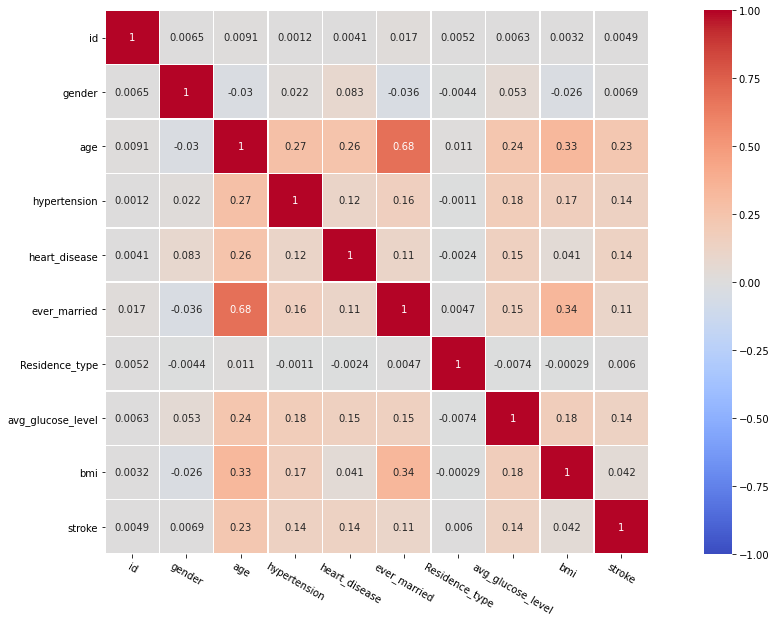

In [18]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),
           vmin = -1,
           vmax = 1,
           cmap=sns.color_palette("coolwarm", as_cmap=True),
           square = True,
           linewidths = 0.5,
           annot=True)

plt.xticks(rotation=-30);